In [43]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [90]:
df = pd.read_csv('training_tweets.csv').drop(columns='Unnamed: 0')
df.head()

,content,sentiment
0,Happy Mama's day to all mothers,love
1,@LysdelTellez I am lost. Please help me find a...,worry
2,"@BoomKatt yes yes I AM, networking whore to th...",happiness
3,you@snapplynn Wish that would have been your t...,neutral
4,now i am doing the MicroEconomics project iha...,worry


In [91]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Preprocesamiento y Feature Engineering

### Atributos

Primero eliminaremos llas observaciones con `sentiment = neutral` y luego hay que procesar el texto de cada tweet (`content`). 

Para esto:

1. Lo pasaremos a minúscula.
2. Lemantizaremos.
3. Convertiremos a una matriz de token counts

Para hacer estos tres pasos utilizaremos `CountVectorizer` y `TweetTokenizer` (código adatado de [aquí](s://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer)):

In [95]:
df = df[df.sentiment != 'neutral']

In [96]:
from nltk import word_tokenize  
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.tknzr = TweetTokenizer()
    def __call__(self, sentences):
        return [self.wnl.lemmatize(t) for t in self.tknzr.tokenize(sentences)]

def get_count_vectorizer():
    return CountVectorizer(tokenizer = LemmaTokenizer(),
                           max_features = 1000,
                           strip_accents = 'unicode',
                           stop_words = 'english',
                           lowercase = True)

### Vector objetivo

El vector objetivo será binario, donde el 1 indicará los casos positivos y el 0 los casos negativos:

In [97]:
y = np.where(np.isin(df.sentiment, ['happiness','love', 'surprise', 'fun', 'relief', 'enthusiasm']), 1, 0)

### Visualización post preprocesamiento

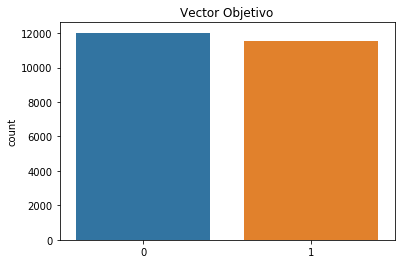

In [98]:
plt.title('Vector Objetivo')
sns.countplot(y);

In [99]:
pd.Series(y).value_counts()

0    12022
1    11527
dtype: int64

Ahora graficaremos las palabras más repetidas usando count vectorizer

In [100]:
X = df.content

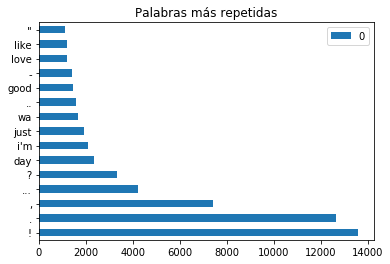

In [101]:
count_vectorizer = get_count_vectorizer()
count_vectorizer_fit = count_vectorizer.fit_transform(X)
count_df = pd.DataFrame(count_vectorizer_fit.toarray(), columns = count_vectorizer.get_feature_names())
best_count = count_df.sum().sort_values(ascending=False)[:15]
best_count.to_frame().plot.barh().set_title('Palabras más repetidas');

## Elección de modelos

Los modelos que utilizaremos serán los siguientes:

In [102]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, confusion_matrix,roc_auc_score

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.33, random_state = 4092019)

In [109]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

In [129]:
params = {
    'tree': { 'max_depth': np.linspace(1, 32, 32), 'max_features': list(range(0, 1000 - 1)) },
    'svm': { 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
}

models = [
    LogisticRegression(),
    DecisionTreeClassifier(random_state = 4092019),
    GridSearchCV(SVC(kernel='rbf'), params['svm'], cv=2),
]

In [ ]:
for i, model in enumerate(models):
    print('===',i,'===')

    pipeline = Pipeline([('count', get_count_vectorizer()),
                      ('model', model)])

    pipeline.fit(X_train, y_train)
    y_hat = pipeline.predict(X_test)

    confusion = confusion_matrix(y_test, y_hat)

    print('Matriz de confusión:\n')
    print(pd.crosstab(y_test, y_hat))

    print('\nReporte de clasificación:\n')
    print(classification_report(y_test, y_hat))

    prob = pipeline.predict_proba(X_test)[:, 1]
    roc = roc_curve(y_test, prob)

    print('\nAUC:', roc_auc_score(y_test, prob), '\n')

=== 0 ===
Matriz de confusión:

col_0     0     1
row_0            
0      2992   967
1      1144  2669

Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      3959
           1       0.73      0.70      0.72      3813

    accuracy                           0.73      7772
   macro avg       0.73      0.73      0.73      7772
weighted avg       0.73      0.73      0.73      7772


AUC: 0.7983123567842347 

=== 1 ===
Matriz de confusión:

col_0     0     1
row_0            
0      2560  1399
1      1373  2440

Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.65      0.65      0.65      3959
           1       0.64      0.64      0.64      3813

    accuracy                           0.64      7772
   macro avg       0.64      0.64      0.64      7772
weighted avg       0.64      0.64      0.64      7772


AUC: 0.6445135547836343 

=== 2 ===
